In [2]:
%pip install matplotlib numpy pandas pyarrow python-snappy bitarray

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


# Acquire Data

In [3]:
import os
import zipfile
import urllib.request
import shutil
from pathlib import Path

url = "https://content.neuralink.com/compression-challenge/data.zip"

data_dir = Path("..") / "data"
if data_dir.exists():
    shutil.rmtree(data_dir)
    data_dir.mkdir()

# download the file
with urllib.request.urlopen(url) as response, open("data.zip", 'wb') as out_file:
    shutil.copyfileobj(response, out_file)

# extract the zip file
with zipfile.ZipFile("data.zip", 'r') as zip_ref:
    zip_ref.extractall("..")

# remove the zip file
os.remove("data.zip")

In [4]:
file_paths = list(data_dir.iterdir())

file_paths[:3]

[PosixPath('../data/8dd8051b-94d0-4c73-9cf4-3447cbb0755d.wav'),
 PosixPath('../data/2a661247-dfa0-42b2-9d0a-a5925ac8735a.wav'),
 PosixPath('../data/e48befb9-a32a-4bcc-af7a-2cd62d76888c.wav')]

# File Analysis

In [5]:
import wave

file_path = file_paths[0]

with wave.open(str(file_path), 'rb') as f:
    num_channels = f.getnchannels()
    sample_rate = f.getframerate()
    sample_width = f.getsampwidth()
    num_frames = f.getnframes()
    duration = num_frames / sample_rate
    compression = f.getcomptype()

    print(f"num_channels: {num_channels}")
    print(f"sample_rate: {sample_rate}")
    print(f"sample_width: {sample_width}")
    print(f"num_frames: {num_frames}")
    print(f"duration: {duration}")
    print(f"compression: {compression}")


num_channels: 1
sample_rate: 19531
sample_width: 2
num_frames: 98634
duration: 5.050125441605653
compression: NONE


Single channel (mono), ~19.5 kHz sample rate, 2-byte samples. Assuming little-endian representation.

In [6]:
import wave

file_path = file_paths[0]

with wave.open(str(file_path), 'rb') as f:
    frames = f.readframes(3)
    for xi, xj in zip(frames[::2], frames[1::2]):
        y = int.from_bytes([xi, xj], byteorder='little', signed=True)
        print(y)


-3235
-4068
-3812


In [7]:
from typing import Collection
from pathlib import Path

def get_samples(path: Path) -> "Collection[int]":
    with wave.open(str(path), 'rb') as f:
        frames = f.readframes(f.getnframes())
        return [int.from_bytes([xi, xj], 'little', signed=True) for xi, xj in zip(frames[::2], frames[1::2])]
    
samples = get_samples(file_paths[0])

print(f"length: {len(samples)}")
print(f"min: {min(samples)}")
print(f"max: {max(samples)}")
print(f"ndv_ratio: {len(set(samples)) / len(samples)}")

length: 98634
min: -10474
max: 12587
ndv_ratio: 0.003507918162094207


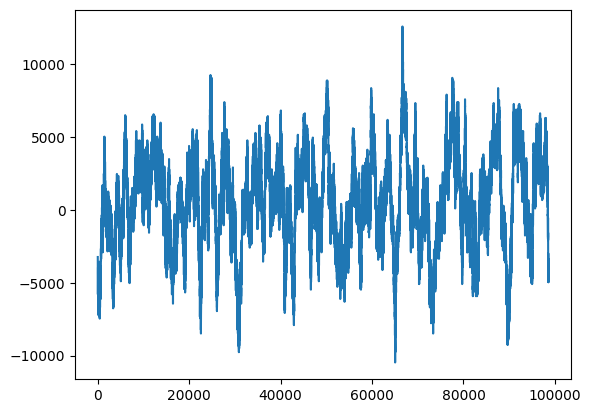

In [8]:
import matplotlib.pyplot as plt

get_samples(file_paths[0])

plt.plot(samples);

# Delta Encoding

In [9]:
from typing import Collection

def delta_encode(x: Collection[int]) -> Collection[int]:
    result = [x[0]]
    for i in range(1, len(x)):
        result.append(x[i] - x[i - 1])
    return result

def delta_decode(x: Collection[int]) -> Collection[int]:
    result = [x[0]]
    for i in range(1, len(x)):
        result.append(result[i - 1] + x[i])
    return result

# tests
delta_test = [1, 3, 6, 10, 15]
assert delta_encode(delta_test) == [1, 2, 3, 4, 5]
assert delta_decode(delta_encode(delta_test)) == delta_test

deltas = delta_encode(samples)

assert samples == delta_decode(deltas)

print(f"length: {len(deltas)}")
print(f"min: {min(deltas)}")
print(f"max: {max(deltas)}")
print(f"ndv_ratio: {len(set(deltas)) / len(deltas)}")

length: 98634
min: -3235
max: 5189
ndv_ratio: 0.0012470344911490966


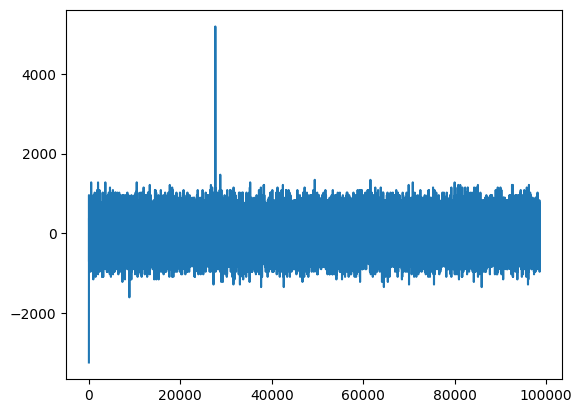

In [10]:
plt.plot(deltas);

In [11]:
ddeltas = delta_encode(deltas)

assert samples == delta_decode(delta_decode(ddeltas))

print(f"length: {len(ddeltas)}")
print(f"min: {min(ddeltas)}")

print(f"max: {max(ddeltas)}")
print(f"ndv_ratio: {len(set(ddeltas)) / len(ddeltas)}")

length: 98634
min: -4997
max: 5253
ndv_ratio: 0.0032747328507411236


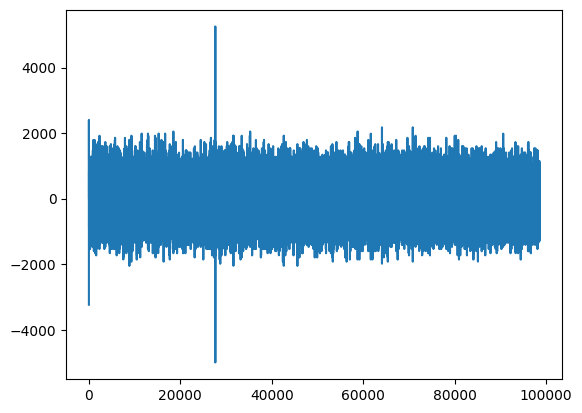

In [12]:
plt.plot(ddeltas);

Delta encoding produces smaller integer values than delta-delta encoding. 

# Dynamic FOR Encoding

Many local areas of the input data share a common frame of reference, where the deviation from the mean is small. This suggests that a dynamic frame-of-reference could be effective.

Delta encoding essentially uses the previous value as the frame of reference. So FOR encoding is redundant prior to delta encoding. However, there are several sections in velocity-space that have a common frame of reference.

4096

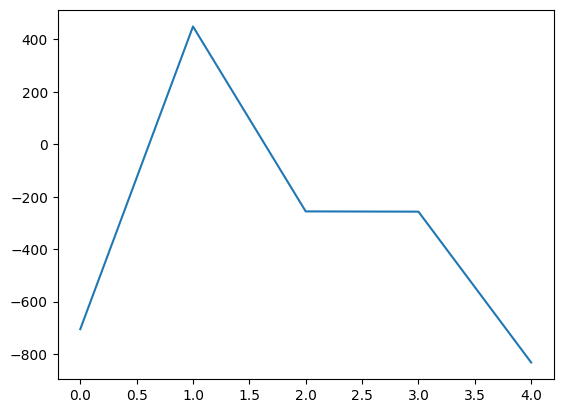

In [115]:
b = 410
plt.plot(deltas[b:b+5]);
2**12

In [ ]:
# dfor metadata format:
#    - Base (must be able to represent as 16-bit signed integer)
#    - Relative start location from previous FOR (must be able to represent as 16-bit unsigned integer)

# as we iterate over integers, behaviour changes whether or not there is an active FOR

from typing import Collection, Tuple

def dfor_encode(x: Collection[int]) -> Tuple[Collection[int], Collection[int]]:
    """
    input: collection of integers
    output: tuple where
        first output is list of 32-bit integers (first 16-bits are base, second 16-bits are relative start location from previous FOR)
        second output is list of bit-packed 16-bit integers
    
    frame of reference ends when any of the following conditions are true
        - current value is more than +-7 away from the base
        - current value is more than 
    """
    pass

# Dictionary Encoding

Due to "bounce" in data, delta-delta encoding (acceleration) is not as effective as delta encoding (velocity). The delta-encoded data has a very low NDV ratio, so dictionary encoding will be effective.

In [90]:
from typing import Collection, Tuple

def dict_encode(x: Collection[int]) -> Tuple[Collection[int], Collection[int]]:
    """
    returns tuple
        where first member is dictionary represented as list of unique values in x
        and second membder is x encoded using dictionary
    """
    d = dict()
    result = list()

    for xi in x:
        if xi not in d:
            d[xi] = len(d)
        result.append(d[xi])

    return list(d.keys()), result

def dict_decode(d: Collection[int], x: Collection[int]) -> Collection[int]:
    """
    returns x decoded using dictionary d
    """
    return [d[xi] for xi in x]

# tests
d, e = dict_encode(samples)
assert dict_decode(d, e) == samples

In [91]:
d, e = dict_encode(deltas)

print(f"length: {len(e)}")
print(f"min: {min(e)}")
print(f"max: {max(e)}")
print(f"ndv_ratio: {len(set(e)) / len(e)}")

print(d[:10])
print(e[100:110])

length: 98634
min: 0
max: 122
ndv_ratio: 0.0012470344911490966
[-3235, -833, 256, 321, -193, -192, 257, -128, -384, -64]
[2, 9, 24, 2, 9, 13, 23, 5, 35, 7]


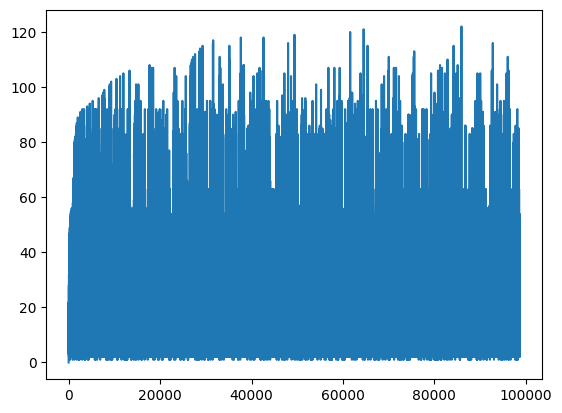

In [92]:
plt.plot(e);

Dictionary-encoded deltas range from 0 to 122. Can be represented using 8-bit unsigned integer.

# Dict-Sort Encoding

Attempt to sort the dictionary and re-encode values. This might be helpful prior to delta encoding, since we'll be measuring the difference in each step.

In [93]:
from typing import Collection, Tuple

def dict_sort(d: Collection[int], x: Collection[int]) -> Tuple[Collection[int], Collection[int]]:
    """
    sorts the dictionary provided in d, then re-encodes values in x
    """
    # clone d
    sd = d[:]
    sorted(sd)

    # create index
    t = {sv: si for si, sv in enumerate(sd)}
    v = dict_decode(d, x)
    se = [t[sv] for sv in v]
    return sd, se

# tests
sd, se = dict_sort(d, e)
assert dict_decode(sd, se) == deltas

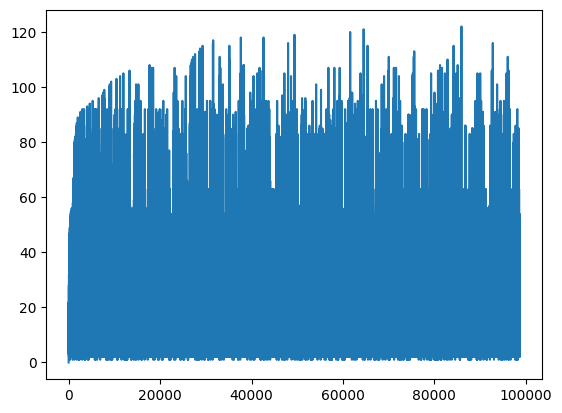

In [95]:
sd, se = dict_sort(*dict_encode(deltas))

plt.plot(se);

In [125]:
len(samples) * 2, len(se)

(197268, 98634)

No use for current implementation.

# Simple-8b Encoding

Since dictionary values are small, with most integer values in the range 0-15, we can efficiently store using fewer bits when possible. Using simple-8b encoding, we store integers in blocks with the bit width of each member stored in the first 4 bits.

This approach requires some additional metadata per block, but given the data skew there is a high likelihood that it will be effective.

In [106]:
from typing import Collection
from bitarray import bitarray
from bitarray.util import pprint

def simple_8b_block_encode(x: Collection[int], width: int) -> bytes:
    assert width in (4, 8, 16), "supported bit-widths are 4, 8, or 16"
    buffer_size = (len(x) * width + 7) // 8
    
    buffer = bytearray(buffer_size)

    for i, value in enumerate(x):
        # Calculate the index in the buffer where this value should be stored
        index = i // (8 // width)

        # Calculate the position within the byte where this value should be stored
        position = (i % (8 // width)) * width

        # Store the value in the buffer
        buffer[index] |= (value << position)

    return bytes(buffer)

def simple_8b_block_decode(x: bytes, width: int) -> Collection[int]:
    assert width in (4, 8, 16), "supported bit-widths are 4, 8, or 16"
    num_values = len(x) * (8 // width)

    values = [0] * num_values

    for i, byte in enumerate(x):
        for j in range(8 // width):
            # Calculate the index in the values list where this value should be stored
            index = i * (8 // width) + j

            # Calculate the position within the byte where this value is stored
            position = j * width

            # Extract the value from the byte
            values[index] = (byte >> position) & ((1 << width) - 1)

    return values

# tests
i = [1, 2, 3, 4, 5, 6]
j = simple_8b_block_encode(i, 4)
k = simple_8b_block_decode(j, 4)

r = bitarray()
r.frombytes(j)
pprint(r)

assert i == k

i = [200, 150, 100, 12, 222, 6]
j = simple_8b_block_encode(i, 8)
k = simple_8b_block_decode(j, 8)

r = bitarray()
r.frombytes(j)
pprint(r)

assert i == k

bitarray('00100001 01000011 01100101')
bitarray('11001000 10010110 01100100 00001100 11011110 00000110')


In [107]:
from typing import Collection, Tuple
from bitarray import bitarray

def encode_simple_8b_header(block_size: int, block_widths: Collection[int]) -> bytes:
    """
    encodes header in the following format
    block_size input must be a power of 2
    [4-bit log block size][2-bit block widths][0-padding to end of byte]
    Where block width values are:
    - 00: end
    - 01: 4
    - 10: 8
    - 11: 16

    since byte ending in 00 indicates end of block widths,
    header must be padded to end of byte. block widths are a multiple of 4
    then need to append a 0-byte to indicate end of block widths
    """
    # ensure block size is power of 2
    assert block_size & (block_size - 1) == 0, "Block size must be a power of 2"

    log_block_size = block_size.bit_length() - 1

    # extend to `log_block_size` 4 bits, padding with 0s
    formatted_log_block_size = bin(log_block_size).lstrip('0b')
    formatted_log_block_size = '0' * (4 - len(formatted_log_block_size)) + formatted_log_block_size

    result = bitarray(formatted_log_block_size)

    for width in block_widths:
        match width:
            case 4:
                result += bitarray('01')
            case 8:
                result += bitarray('10')
            case 16:
                result += bitarray('11')
            case _:
                raise ValueError(f"Invalid block width: {width}")

    result += bitarray('00')

    while len(result) % 8 != 0:
        result += bitarray('00')

    return bytes(result)

def decode_simple_8b_header(x: bytes) -> Tuple[int, Collection[int]]:
    buffer = bitarray()
    buffer.frombytes(x)

    log_block_size = int.from_bytes(bytes(buffer[:4]), 'little', signed=False) >> 4
    block_size = 2 ** log_block_size

    block_widths = list()
    for i in range(4, len(buffer), 2):
        y = buffer[i:i + 2]
        
        if y == bitarray('00'):
            break
        elif y == bitarray('01'):
            block_widths.append(4)
        elif y == bitarray('10'):
            block_widths.append(8)
        elif y == bitarray('11'):
            block_widths.append(16)

    return block_size, block_widths
    

# tests
i = encode_simple_8b_header(8, [4, 8, 16])
assert i == bytes(bitarray('00110110 11000000')) # 0011 0110 1100 0000
j, k = decode_simple_8b_header(i)
assert j == 8
assert k == [4, 8, 16]

In [123]:
from typing import Collection

def simple_8b_encode(x: Collection[int], block_size: int = 16) -> bytes:
    """
    input:
        - x is input array of 16-bit unsigned integers
        - block_size is number of integers include in each block
    output:
        bytes object where integers are encoded in blocks
        first 4-bits of each block is bit-width of each encoded value
        each subsequent value is encoded using the bit-width of the block
    """
    block_widths = []
    blocks = []

    for i in range(0, len(x), block_size):
        block = x[i:i + block_size]

        if not block:
            break

        if max(block) < 2 ** 4:
            block_widths.append(4)
            blocks.append(simple_8b_block_encode(block, 4))
        elif max(block) < 2 ** 8:
            block_widths.append(8)
            blocks.append(simple_8b_block_encode(block, 8))
        else:
            block_widths.append(16)
            blocks.append(simple_8b_block_encode(block, 16))
    
    result = encode_simple_8b_header(block_size, block_widths)
    for block in blocks:
        result += block

    return result

def simple_8b_decode(x: bytes) -> Collection[int]:
    """
    input:
        - x is the input bytes object containing encoded blocks
        - block_size is the number of integers included in each block
    output:
        list of decoded 16-bit unsigned integers
    """
    block_size, block_widths = decode_simple_8b_header(x)
    blocks = x[len(encode_simple_8b_header(block_size, block_widths)):]

    result = []
    for i in range(0, len(blocks), block_size):
        block = blocks[i:i + block_size]
        if not block:
            break

        if block_widths[i // block_size] == 4:
            result += simple_8b_block_decode(block, 4)
        elif block_widths[i // block_size] == 8:
            result += simple_8b_block_decode(block, 8)
        else:
            result += simple_8b_block_decode(block, 16)

    return result

j = simple_8b_encode(e, 4)

# assert simple_8b_decode(j) == e

len(e), len(j)

(98634, 102424)

In [116]:
len(e) / len(j)

0.9833702219297721

Current implementation is not effective.

# Visualization

In [117]:
import pandas as pd

# position, velocity, & dict-encoded velocity
df = pd.DataFrame({"x": samples, "v": deltas, "a": delta_encode(deltas), "e": e})

df.head()

,x,v,a,e
0,-3235,-3235,-3235,0
1,-4068,-833,2402,1
2,-3812,256,1089,2
3,-3491,321,65,3
4,-3684,-193,-514,4


In [117]:
import pandas as pd

# dictionary
df = pd.DataFrame({"k": range(0, len(d)), "v": d})

df.head()

,k,v
0,0,-3235
1,1,-833
2,2,256
3,3,321
4,4,-193


# Output Format

Current best results acheived with following approach:
- Delta encoding (reduces range & increased NDV ratio)
- Dictionary encoding (only 8-bits required to represent each value)

To store this encoding, the following output layout is used:
- Encoded samples (Variable size 8-bit unsigned integer sequence)
- Dictionary (Variable size 16-bit signed integer sequence)
- Length (4-byte unsigned integer representing the number of samples in the encoded sequence)

In [76]:
from typing import Collection

def encode(x: Collection[int]) -> bytes:
    """
    applies delta+dict encoding to `x`
    output is bytes in the following format:
        - encoded samples (8-bit unsigned integers)
        - dictionary (16-bit unsigned integers)
        - sample length (4-byte unsigned integer)
    """
    d, e = dict_encode(delta_encode(x))

    ebytes = b''.join([xi.to_bytes(1, 'little', signed=False) for xi in e])
    dbytes = b''.join([xi.to_bytes(2, 'little', signed=True) for xi in d])
    length = len(ebytes).to_bytes(4, 'little', signed=False)

    return ebytes + dbytes + length

def decode(x: bytes) -> Collection[int]:
    """
    input is bytes in the following format:
        - Encoded samples (8-bit unsigned integers)
        - Dictionary (16-bit unsigned integers)
        - 4-byte length of encoded samples
    output is decoded samples
    """
    l = int.from_bytes(x[-4:], 'little', signed=False)
    d = [int.from_bytes(x[i:i+2], 'little', signed=True) for i in range(l, len(x) - 4, 2)]
    e = [int.from_bytes(x[i:i+1], 'little', signed=False) for i in range(0, l)]

    return delta_decode(dict_decode(d, e))

encoded = encode(samples)

encoded[:100]

assert samples == decode(encoded)

e[0:10]

[0, 1, 2, 3, 4, 5, 6, 4, 7, 8]

# Compression

In [89]:
with wave.open(str(file_path), 'rb') as f:
    frames = f.readframes(f.getnframes())
    raw_bytes = len(frames)
    print(f"raw_bytes: {raw_bytes}")
    print(f"encoded_bytes: {len(encoded)}")
    print(f"encoding_ratio: {len(encoded) / raw_bytes}")

raw_bytes: 197268
encoded_bytes: 98884
encoding_ratio: 0.501267311474745


In [90]:
import snappy

compressed = snappy.compress(encoded, encoding=None)

compressed_size_bytes = len(compressed)

print(f"compression_bytes: {compressed_size_bytes}")

compression_bytes: 98892


Snappy compression provides no benefit.

In [91]:
compression_ratio = len(encoded) / raw_bytes

print(f"compression_ratio: {compression_ratio}")

compression_ratio: 0.501267311474745
